
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [192]:
import autograd.numpy as np 
from autograd import jacobian, hessian
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep



## 1.general parameters

In [193]:
nside = 64
model = 'd0s0'

Load the instrument

In [194]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

n_freqs=len(instrument.frequency)
n_stokes=3

Get the frequency maps 

In [195]:
freq_maps_N = get_observation(instrument, model, noise=True, nside=nside)
freq_maps = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= freq_maps_N[:,1:,:]
freq_maps= freq_maps[:,1:,:]


Chose the components to fit for

In [196]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [197]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)


Define the noise covariance matrix

In [198]:
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)


## 2.component separation

true and initial values for the parameters

In [199]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))

x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40))

#### average spectral likelihood

In [200]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(M_ev(np.array([1.54,20,-3])).shape)


(22, 3)


In [201]:

def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

In [202]:
aver_likelihood(x_true)

-31300490262.321014

#### step1: minimization of the average spectral likelihood

In [203]:
bnds = ((1.4, 1.6), (10, 30), (-3.5,-2.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5))
options={'maxfun':50000}
result= minimize(aver_likelihood, x_true, method='TNC', tol = 1e-18, options=options, bounds=bnds )
print(result)
print(result.x)

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -31300490262.321053
       x: [ 1.540e+00  2.000e+01 ...  1.000e+00  1.000e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00 ...  1.526e+03  7.629e+02]
    nfev: 700
[ 1.54       19.99999999 -3.          0.99999998  0.99999998  1.
  0.99999998  0.99999998  1.00000001  0.99999999  0.99999998  1.
  1.          1.          0.99999998  1.00000001  0.99999999  0.99999999
  0.99999999  0.99999998  0.99999998  0.99999998  1.00000001  0.99999995]


Calculate the errors of the parameters

In [204]:
H = nd.Hessian(aver_likelihood)
h = H(result.x)

sigma_params_square = np.linalg.inv(h)

definition of A=G*M

In [205]:
def G_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    return G

In [206]:
def A_ev_new(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    gain_params= [a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ]
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
#   G = G(gain_params)
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs])))
    print(A_maxL.shape)
    return A_maxL

In [207]:
#evaluate the matrix A at maximum of the average likelihood

A_maxL=A_ev_new(result.x) #(n_freq,n_component)





(22, 3)


#### step2: take the component maps (residual, dust, synch)
the first one should be CMB, but I have no CMB, so it is residual

In [208]:



AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)


W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)


residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))


## 3. total residual power spectrum

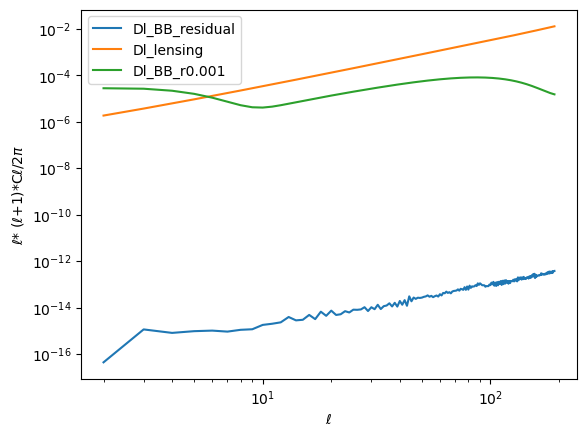

In [209]:
#multipole range 
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

#power spectrum of the total residual 
Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:] #with [2] I select the B mode
Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


#Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][lmin:lmax]
#Dl theory
Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


#lensing
Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

#plot power spectra
plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



## 4.Calculate sigma Fisher

In [210]:
Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
sigma_r_fisher = np.sqrt(1.0 / F)

## estimation of the statistical and systematics residuals

In [211]:
i_cmb = M.components.index('CMB')

#residual (n_component,n_freq)
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)#[i_cmb,:]



#this function takes the gain parameters 21 from the minimization and add the one that is fixed at 1
def G_values_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = [a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z]
    return G

gain_params_tot= G_values_tot(result.x[3:])


#it gives you the derivative of the gain respect to each gains
def G_diff(gain_params_tot_):
    G_dB = []
    for i,_ in enumerate(result.x[3:]):
        zeros= np.zeros((len(gain_params_tot_),len(gain_params_tot_)))
        zeros[i] = 1
        G_dB.append(zeros)
    return np.array(G_dB)



def zeros(M_dB_):
    M_dB=[]
    zero_column=np.zeros(22)
    for i,_ in enumerate(result.x[:3]):
        if i == 2: 
            M_dB_tot=np.vstack((zero_column,zero_column,M_dB_[i,:,0]))   
        else:
            M_dB_tot=np.vstack((zero_column,M_dB_[i,:,0], zero_column))
        M_dB.append(M_dB_tot)
    return np.array(M_dB)


def A_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    

    #first term
    G_dB=G_diff(gain_params_tot)  #(gain,freq,freq)=(21,22,22)
    M_ev_val = M_ev(spectral_params_values) #(freq,component)=(22,3)
    G_dB_M = np.zeros((24,22,3))
    # derivatives of G wrt. spectral parameters is zero
    G_dB_M[3:,:] = np.einsum('gif, fc-> gic',  G_dB, M_ev_val) #(number of derivatives(gain), freq, component)= (21,22,3) 
    

    #second term
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(spec_params,component,freq)=(3,3,22)
    M_dB_tot=np.array(M_dB_tot)
    
   

    G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    G_M_dB_val = np.zeros((24,22,3))
    G_M_dB_val[:3,:] = np.einsum('scf, fg-> sgc', M_dB_tot,G) #(number of derivatives(spect), freq, component)= (3,22,3)

    
    
    A_dB_new= np.add(G_dB_M,G_M_dB_val)#(params_tot,freq,component)=(24,22,3)
    return A_dB_new



A_dB_maxL= A_diff_new(result.x)


In [212]:
#here all the shape that I need to control for the long formula below of W_dB_maxL

print(A_maxL.T.shape)
print(invN.shape)
print(A_maxL.shape)

print(A_dB_maxL.T.shape)
print(A_dB_maxL.shape)

(3, 22)
(22, 22)
(22, 3)
(3, 22, 24)
(24, 22, 3)


In [213]:
#with the dot method it doesn't work because as you see in the photo that I sent to you on Slack 
#the yellow calculation is a problem if I do not control the position of the components ... so I used the Einstein sum
#W_dB_maxL= -np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL)).dot((A_dB_maxL.T.dot(invN).dot(A_maxL)+A_maxL.T.dot(invN).dot(A_dB_maxL))).dot(np.linalg.inv(A_maxL.T.dot(invN).dot(A_dB_maxL))) + np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL)).dot(A_dB_maxL.T).dot(invN)



#legend in the Slack photo
a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))
b = np.einsum('cfg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gxs-> cgs',A_maxL.T, invN, A_dB_maxL)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))
d = np.einsum('cfg, fx-> cgx',A_dB_maxL.T, invN)


W_dB_maxL = np.einsum('cx, xgi, iy-> cgy', a , b, c) + np.einsum('cx, xgf-> cgf', c, d)

print(W_dB_maxL.shape)

ValueError: operands could not be broadcast together with shapes (3,24,3) (3,24,22) 

In [ ]:




# W_dB_maxL = W_dB(A_maxL, A_dB_maxL, M.comp_of_dB, invN=invN)[:, i_cmb]
# W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,M.comp_of_dB, invN=invN)[:, :, i_cmb]

# print(W_maxL.shape)
# print(W_dB_maxL.shape)
# print(W_dBdB_maxL.shape)
# V_maxL = np.einsum('ii,xyz->...', sigma_params_square, W_dBdB_maxL)


# #Cl
# if n_stokes == 3:  
#     d_spectra = freq_maps_N
# else:  # Only P is provided, add T for map2alm
#     d_spectra = np.zeros((n_freqs, 3, freq_maps_N.shape[2]), dtype=freq_maps_N.dtype)
#     d_spectra[:, 1:] = freq_maps_N


# # almBs = [hp.map2alm(freq_maps_N, lmax=lmax, iter=10)[2] for freq_map in freq_maps_N]
# Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
# # for f1 in range(n_freqs):
# #     for f2 in range(n_freqs):
# #         if f1 > f2:
# #             Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
# #         else:
# #             Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

# # Cl_fgs = Cl_fgs[..., lmin:] / fsky

# Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]





# Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# # elementary quantities defined in Stompor, Errard, Poletti (2016)
# Cl_xF = {}
# Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
# Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
# # Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
# Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
# # Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)



# # bias and statistical foregrounds residuals
# noise = Cl_noise
# bias = 0
# stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  # E11, Eq. 12
# var = stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
#                                           Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])

# # control
# BB_residual=noise+stat
# print(BB_residual)
# print(Cl_BB_residual)



In [ ]:

# W_dB_maxL= -np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL)).dot((A_dB_maxL.dot(invN).dot(A_maxL)+A_maxL.T.dot(invN).dot(A_dB_maxL))).dot(np.linalg.inv(A_maxL.T.dot(invN).dot(A_dB_maxL))) + np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL)).dot(A_dB_maxL).dot(invN)
# print(W_dB_maxL.shape)

# #second derivative (3, 2, 3, 22)
# W_dBdB_maxL = np.gradient(W_dB_maxL)# [:, :, i_cmb]
# W_dBdB_maxL=np.array(W_dBdB_maxL)
# # print(W_dBdB_maxL.shape)

# V_maxL = np.einsum('ij,ij...->...', sigma_params_square, W_dBdB_maxL)
# almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in freq_maps]

# #Cl
# Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
# for f1 in range(n_freqs):
#     for f2 in range(n_freqs):
#         if f1 > f2:
#             Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
#         else:
#             Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

# Cl_fgs = Cl_fgs[..., lmin:] / fsky

# Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]



# # elementary quantities defined in Stompor, Errard, Poletti (2016)
# Cl_xF = {}
# Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
# Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
# Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
# Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
# Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)


# #residual results
# noise = Cl_noise
# bias = Cl_xF['yy'] + 2 * Cl_xF['yz'] #0
# stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  
# var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])

# #control
# BB_residual=noise+stat
# print(BB_residual)
# print(Cl_BB_residual)
